# Contructing the neighbor list

In this notebook I will briefly show the construction of the neighbor list for a 3D system. The neighbor list is a list of all the particles that are within a certain distance of a given particle. This is a very useful tool in molecular dynamics simulations, as it allows to calculate the forces between particles in a more efficient way.

The implementation here will be **as minimal as possible** and when translated into our Rust code - it will use a couple of tricks there to optimize the performance.

## Preliminaries

First we need to set up a basic data structure for out particles and the neighbours list. We will use a simple dataclass for the particles and dictionary for the neighbours list, due to its $O(1)$ access time.

In [1]:
import dataclasses

@dataclasses.dataclass
class Particle:
    x: float
    y: float
    z: float

    def calculate_distance(self, other: "Particle") -> float:
        return abs(self.x - other.x) + abs(self.y - other.y) + abs(self.z - other.z)

    def __repr__(self) -> str:
        return f"({self.x}, {self.y}, {self.z})"


@dataclasses.dataclass
class NeighborsList:
    cutoff: float
    neighbors: dict[int, list[tuple[int, float]]] = dataclasses.field(init=False, default_factory=dict)

    def update(self, particles: list[Particle]) -> None:
        pass

    def __repr__(self) -> str:
        print(f"NeighborsList(cutoff={self.cutoff})")
        for particle, neighbors in self.neighbors.items():
            print(f"\t {particle}: {neighbors}")

As You can see, the data structures themselves are rather simple. The `Particle` class will hold the position expressed
as Cartesian coordinates and the `NeighborsList` will be our local neighborhood cache with a set cutoff distance.

What we need to implement right now is the `update` method of `NeighborsList` that will record find all neighbors
of an $i-th$ atom by looking at other particles with indices $j > i$ since there is no need to check pair $(j,i)$ if
pair $(i,j)$ was already verified to be close neighbours or not.

If two particles are deemed to be close (below cutoff), then their indices and relative distance will be kept in the
cache, to reduce future computations.

In [2]:
def update(self: NeighborsList, particles: list[Particle]):
    number_of_particles: int = len(particles)
    for i in range(0, number_of_particles):
        if i not in self.neighbors:
            self.neighbors[i] = []
        for j in range(i+1, number_of_particles): # j+1 to avoid double counting
            if j not in self.neighbors:
                self.neighbors[j] = []
            if distance := particles[i].calculate_distance(particles[j]) < self.cutoff:
                # Add j to the list of neighbors of i
                # and add i to the list of neighbors of j (since the pair is symmetric)
                self.neighbors[i].append((j, distance))
                self.neighbors[j].append((i, distance))
NeighborsList.update = update  # This is how we add a method to a class after it has been defined (monkey patching)

After implementing this, we will be able to visualize the results and see how the neighbor list is constructed.
Most importantly, we can compare the performance of the brute force method with the neighbor list method, for
different number of particles and different cutoff distances.

In [3]:
# This part is similar to the crystal lattice we've constructed in Part I - basis + dimension

def construct_lattice(base_distance: float, number_of_repetitions: int, base_particles: list[Particle]) -> list[Particle]:
    particles = []
    for i in range(0, number_of_repetitions):
        for j in range(0, number_of_repetitions):
            for k in range(0, number_of_repetitions):
                for particle in base_particles:
                    x_position = (particle.x + i) * base_distance
                    y_position = (particle.y + j) * base_distance
                    z_position = (particle.z + k) * base_distance
                    particles.append(Particle(x_position, y_position, z_position))
    return particles


Using the function above we will create an interface that will allow us to create a 3D system of particles and visualize the neighbor list.
To simulate a case when no neighbor list is used, we can set the cutoff distance to be very large, so that all particles will be considered neighbors.

In [4]:
import micropip
await micropip.install("ipywidgets")

import ipywidgets
import matplotlib.pyplot as plt

FCC_BASIS = [
    Particle(0, 0, 0),
    Particle(0.5, 0.5, 0),
    Particle(0.5, 0, 0.5),
    Particle(0, 0.5, 0.5),
]
LATTICE_CONSTANT = 4.2
NUMBER_OF_REPETITIONS = 3
CHOSEN_PARTICLE_ID = int(len(FCC_BASIS) * NUMBER_OF_REPETITIONS ** 3 / 2)

def plot_particles(cutoff: float) -> None:
    particles = construct_lattice(LATTICE_CONSTANT, NUMBER_OF_REPETITIONS, FCC_BASIS)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    fig.suptitle(f"Lattice constant = {LATTICE_CONSTANT}, cutoff = {cutoff}")

    neighbors_list = NeighborsList(cutoff)
    neighbors_list.update(particles)

    plt.xlim(-0.5*LATTICE_CONSTANT, (NUMBER_OF_REPETITIONS) * LATTICE_CONSTANT)
    plt.ylim(-0.5*LATTICE_CONSTANT, (NUMBER_OF_REPETITIONS) * LATTICE_CONSTANT)

    # Plot a black dot for the chosen particle
    chosen_particle = particles[CHOSEN_PARTICLE_ID]
    ax.scatter(chosen_particle.x, chosen_particle.y, chosen_particle.z, c="black", zorder=10)

    counter = 0
    # Plot a red dot for each neighbor of the chosen particle
    for neighbor_id, _ in neighbors_list.neighbors[CHOSEN_PARTICLE_ID]:
        neighbor = particles[neighbor_id]
        counter += 1
        ax.scatter(neighbor.x, neighbor.y, neighbor.z, c="red", zorder=10)

    plt.title(f"Number of neighbors = {counter} vs. {len(particles) - 1} (all other particles)")
    
    # Plot a blue dot for all non-neighbors of the chosen particle
    for i, particle in enumerate(particles):
        if i != CHOSEN_PARTICLE_ID and i not in [neighbor_id for neighbor_id, _ in neighbors_list.neighbors[CHOSEN_PARTICLE_ID]]:
            ax.scatter(particle.x, particle.y, particle.z, c="blue", zorder=10, alpha=0.25)

    plt.margins(0.1)
    plt.show()

ipywidgets.interact(
    plot_particles,
    cutoff=ipywidgets.FloatSlider(min=0.0, max=(NUMBER_OF_REPETITIONS + 2) * LATTICE_CONSTANT, step=(NUMBER_OF_REPETITIONS + 2) * LATTICE_CONSTANT / 100, value=3.0),
)
print("")

interactive(children=(FloatSlider(value=3.0, description='cutoff', max=21.0, step=0.21), Output()), _dom_class…

The gradual increase of red neighbors in the plot will show how the neighbor list is constructed and how its size can grow with the choice of the cutoff distance.
The way in which each population of neighbors suddenly increases after a certain distance means that there are intervals of distances where the number of neighbors is constant. Those are basically neighborhoods of a particle **with different orders**, which correspons to a group of red particles with cutoff distance $r$ in the range of $\langle4.2, \mathrm{approx.}~8.2)$ (please don't kill me for that notation).

Potentials can also be divided into different categories based on their "neighbourhood-ness" or how many orders of neighbourhoods they affect. This is a very important concept in molecular dynamics simulations and it is the reason why neighbor lists are so important. But what about computational time? Let's see how the computational time scales with the number of particles and the cutoff distance. We will introduce some bogus operation performed for each atomic pair that will roughly correspond to calculating the force between them. The number of particles will be set to resemble the amount normally used in molecular dynamics simulations e.g. $10^3 - 10^6$.

Next we will implement the sudo-forces calculation and compare the time it takes to calculate the forces using two types of neighbor lists:

1. A list of cutoff $r_\mathrm{cut} \rightarrow \infty$ or, in other words, f*?!#ing huge.
2. A list of cutoff $r_\mathrm{cut} = \sqrt{\mathrm{Lattice~constant}}$.

The test will be performed for different number of particles expressed as number of unit cells in a cubic lattice (repetitions along each dimension).
The range of repetitions will be from $2$ to $20$ and the lattice constant will be set to $4.2$.

In [15]:
import time
import sys
import math

LATTICE_CONSTANT = 4.2


def kind_of_force_calculation(distance: float) -> float:
    return 1 / distance ** 12 - 1 / distance ** 6


def mimic_calculating_forces(neighbors_list: NeighborsList) -> None:
    for i in neighbors_list.neighbors:
        for _, distance in neighbors_list.neighbors[i]:
            kind_of_force_calculation(distance)


def measure_runtime(neighbors: NeighborsList):
    stopwatch_start = time.time()
    mimic_calculating_forces(neighbors)
    return time.time() - stopwatch_start


def compare_runtimes(constant: float, repetitions: int) -> tuple[int, float, float]:
    particles = construct_lattice(constant, repetitions, FCC_BASIS)

    huge_cutoff_neighbors_list = NeighborsList(constant * sys.maxsize)
    huge_cutoff_neighbors_list.update(particles)
    normal_cutoff_neighbors_list = NeighborsList(math.sqrt(constant))
    normal_cutoff_neighbors_list.update(particles)

    del particles

    return (
        repetitions,
        measure_runtime(huge_cutoff_neighbors_list),
        measure_runtime(normal_cutoff_neighbors_list)
    )

print("Measuring runtimes...")
results = [
    compare_runtimes(LATTICE_CONSTANT, repetitions)
    for repetitions in range(2, 11)
]
print("Done!")

Measuring runtimes...
Done!


Having our times measured, we will be able to see how the computational time scales with the number of particles and the cutoff distance. This will allow us to see the importance of the neighbor list in molecular dynamics simulations and how the computational time scales with the number of particles and the cutoff distance. To make the comparison more clear, we will plot the speedup of the neighbor list method over the brute force method.

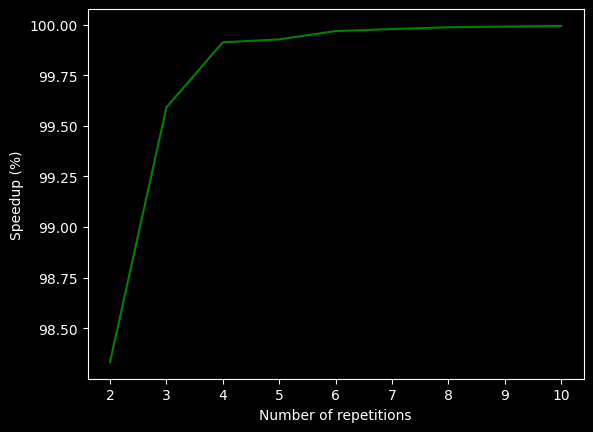

In [16]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_xlabel("Number of repetitions")
ax.set_ylabel("Speedup (%)")

speedup = [
    100 * (huge_cutoff_time - normal_cutoff_time) / huge_cutoff_time
    for _, huge_cutoff_time, normal_cutoff_time in results
]

ax.plot(
    [repetitions for repetitions, _, _ in results],
    speedup,
    color="green",
)

plt.style.use("dark_background")

plt.show()

The results speak for themselves. The neighbor list method is much faster than the brute force method, especially for large number of particles. For especially large systems, it tends to the magical 100% of speedup, which means that the computational time is halved. This is a very important result, as it shows that the neighbor list is a very important tool in molecular dynamics simulations and that it can greatly reduce the computational time.

Knowing that and having our basis for neighbours list implementation, we can finally jump into writing some code in Rust! 👨‍💻🦀